# GOES ABI, MODIS, ASTER Comparison
## Compute summary statistics for their ~11 micron TIR bands

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import xarray as xr
import os
import glob

# for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

# for plotting ASTER geotiffs
import rasterio as rio
import rasterio.plot as rioplt
from rasterio.warp import calculate_default_transform

# for working with raster data
import rioxarray

# for shapefile
import geopandas as gpd

# for MODIS conversions
import modis_utils

# for calculating zonal statistics
import aster_utils

# for GOES
import goes_utils

import warnings
warnings.filterwarnings('ignore')

Set font sizes for plots

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Define some funcitons I'll use below

In [3]:
# use this function to match the date/time of observations
def nearest(items, pivot):
    # https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

In [4]:
def summary_stats(a, b):
    '''Compute summary statistics for the difference between two sets.
    Input two flattened (1-D) arrays with NaN values removed'''
    
    # remove nan values
    a = a[np.isnan(a)==False]
    b = b[np.isnan(b)==False]
    
    # for difference stats
    diff = b - a
    
    # for linear regression stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(a, b)
    
    # populate dict with summary stats
    summary_stats_dict = {
        #'diff' : diff ,
        'n' : len(diff) ,
        'mean_diff' : np.nanmean( diff ),
        'median_diff' : np.nanmedian( diff ),
        'mean_squared_diff' : np.nanmean( diff**2 ),
        'rms_diff' : np.sqrt( np.nanmean( diff**2 ) ),
        'std_diff' : np.nanstd( diff ),
        'slope' : slope,
        'intercept' : intercept,
        'r_value' : r_value,
        'p_value' : p_value,
        'std_err' : std_err
        }
    
    return summary_stats_dict

In [5]:
def make_summary_plots(aster, modis, goes, summary_stats_dict, show_figure=True, save_figure=False):
    
    '''Function for making plots'''
    
    ######## Compute difference rasters
    # make sure to use MODIS band 31 (here index 10, it is around 11 microns)
    # See a list of band numbers with: modis_ds_repr_match.band_names.split(',')
    modis_band_index = 10
    # ASTER - MODIS
    diff_ast_mod = modis - aster
    # ASTER - GOES
    diff_ast_goes = goes - aster
    # MODIS - GOES
    diff_mod_goes = goes - modis
    
    ##### Make Plot
    fig = plt.figure(figsize=(20,27),
                           tight_layout=True)
    
    ##### Format figure subplots with subplot2grid:
    ##### ax = subplot2grid((nrows, ncols), (row, col), rowspan, colspan)
    
    nrows = 5
    ncols = 3
    
    ax_ast_top = plt.subplot2grid((nrows, ncols), (0, 0), 1, 1)
    ax_mod_top = plt.subplot2grid((nrows, ncols), (0, 1),  1, 1)
    ax_goes_top = plt.subplot2grid((nrows, ncols), (0, 2), 1, 1)
    
    ax_ast_mod = plt.subplot2grid((nrows, ncols), (1, 0), 1, 1)
    ax_ast_goes = plt.subplot2grid((nrows, ncols), (1, 1), 1, 1)
    ax_mod_goes = plt.subplot2grid((nrows, ncols), (1, 2), 1, 1)
    
    ax_ast_mod_hist = plt.subplot2grid((nrows, ncols), (2, 0), 1, 1)
    ax_ast_goes_hist = plt.subplot2grid((nrows, ncols), (2, 1), 1, 1)
    ax_mod_goes_hist = plt.subplot2grid((nrows, ncols), (2, 2), 1, 1)
    
    ax_ast_mod_1_to_1 = plt.subplot2grid((nrows, ncols), (3, 0), 1, 1)
    ax_ast_goes_1_to_1 = plt.subplot2grid((nrows, ncols), (3, 1), 1, 1)
    ax_mod_goes_1_to_1 = plt.subplot2grid((nrows, ncols), (3, 2), 1, 1)
        
    blank = plt.subplot2grid((nrows, ncols), (4, 0), 3, 1)
    blank.set_axis_off()
    
    ### Top Row plot original images ###
    # ASTER TB C (band 14, 11 micron)
    aster.plot(ax=ax_ast_top, cmap='Greys', vmin=0, vmax=10)
    ax_ast_top.set_title("ASTER Band 14 (~$11 \mu m$) Radiance\n[$W m^{-2} sr^{-1} um^{-1}$]")
    # MODIS TB C (band 31 (index 10), 11 micron)
    modis.plot(ax=ax_mod_top, cmap='Greys', vmin=0, vmax=10)
    ax_mod_top.set_title("MODIS Band 31 (~$11 \mu m$) Radiance\n[$W m^{-2} sr^{-1} um^{-1}$]")
    # GOES ABI TB C (band 14, 11 micron)
    goes.plot(ax=ax_goes_top, cmap='Greys', vmin=0, vmax=10)
    ax_goes_top.set_title("GOES-16 Band 14 (~$11 \mu m$) Radiance\n[$W m^{-2} sr^{-1} um^{-1}$]")
    
    
    ### Difference Plots ###
    # Difference: ASTER - MODIS
    diff_ast_mod.plot(ax=ax_ast_mod, cmap='RdBu_r', vmin=-2, vmax=2)
    ax_ast_mod.set_title('MODIS - ASTER');
    # Difference: ASTER - GOES
    diff_ast_goes.plot(ax=ax_ast_goes, cmap='RdBu_r', vmin=-2, vmax=2)
    ax_ast_goes.set_title('GOES - ASTER');
    # Difference: MODIS - GOES
    diff_mod_goes.plot(ax=ax_mod_goes, cmap='RdBu_r', vmin=-2, vmax=2)
    ax_mod_goes.set_title('GOES - MODIS');
    
    # common axes formatting for all map plots
    for ax_map in [ax_ast_top, ax_mod_top, ax_goes_top, ax_ast_mod, ax_ast_goes, ax_mod_goes]:
        # add titles to axes
        ax_map.set_xlabel('Eastings (UTM 11N) [m]')
        ax_map.set_ylabel('Northings (UTM 11N) [m]')
        # set axes limits to our bounding geometry
        ax_map.set_xlim((utm_eastings_min, utm_eastings_max))
        ax_map.set_ylim((utm_northings_min, utm_northings_max))
    
    diff_min = 0
    diff_max = 10
    
    ### Difference Histograms ###
    # Difference Histogram: ASTER - MODIS
    diff_ast_mod.plot.hist(bins=100, ax=ax_ast_mod_hist, facecolor='k');
    ax_ast_mod_hist.axvline(summary_stats_dict['ast_mod_mean_diff'], color='r', linestyle='--')
    ax_ast_mod_hist.axvline(summary_stats_dict['ast_mod_median_diff'], color='r', linestyle=':')
    ax_ast_mod_hist.set_title('MODIS - ASTER');
    # Difference Histogram: ASTER - GOES
    diff_ast_goes.plot.hist(bins=100, ax=ax_ast_goes_hist, facecolor='k');
    ax_ast_goes_hist.axvline(summary_stats_dict['ast_mod_mean_diff'], color='r', linestyle='--')
    ax_ast_goes_hist.axvline(summary_stats_dict['ast_mod_median_diff'], color='r', linestyle=':')
    ax_ast_goes_hist.set_title('GOES - ASTER');
    # Difference Histogram: MODIS - GOES
    diff_mod_goes.plot.hist(bins=100, ax=ax_mod_goes_hist, facecolor='k');
    ax_mod_goes_hist.axvline(summary_stats_dict['mod_goes_mean_diff'], color='r', linestyle='--')
    ax_mod_goes_hist.axvline(summary_stats_dict['mod_goes_median_diff'], color='r', linestyle=':')
    ax_mod_goes_hist.set_title('GOES - MODIS');
    # common formatting across all hist plots
    for ax_hist in [ax_ast_mod_hist, ax_ast_goes_hist, ax_mod_goes_hist]:
        ax_hist.set_xlim((-2.5,2.5))
        ax_hist.set_ylim((0,5000))
        ax_hist.set_xlabel('Pixel Count (30m)')
        ax_hist.set_xlabel('Radiance Difference [$W m^{-2} sr^{-1} um^{-1}$]')
    
    ### 1-to-1 plots ###
    # ASTER vs MODIS
    #ax_ast_mod_1_to_1.plot(modis_ds_repr_match.tb_c.isel(band=modis_band_index).values.ravel(), aster_tb_degC.values.ravel(), '.k', alpha=0.01)
    ax_ast_mod_1_to_1.hist2d(modis.values.ravel(), aster.values.ravel(), bins=int((diff_max - diff_min)*5), cmap='Greys', range=[[diff_min, diff_max], [diff_min, diff_max]], density=True)
    ax_ast_mod_1_to_1.set_ylabel('ASTER $~11 \mu m$ Radiance [$W m^{-2} sr^{-1} um^{-1}$]')
    ax_ast_mod_1_to_1.set_xlabel('MODIS $~11 \mu m$ Radiance [$W m^{-2} sr^{-1} um^{-1}$]')
    ax_ast_mod_1_to_1.set_title('ASTER vs MODIS');
    # ASTER vs GOES
    #ax_ast_goes_1_to_1.plot(goes_img_degC.values.ravel(), aster_tb_degC.values.ravel(), '.k', alpha=0.01)
    ax_ast_goes_1_to_1.hist2d(goes.values.ravel(), aster.values.ravel(), bins=int((diff_max - diff_min)*5), cmap='Greys', range=[[diff_min, diff_max], [diff_min, diff_max]], density=True)
    ax_ast_goes_1_to_1.set_ylabel('ASTER $~11 \mu m$ Radiance [$W m^{-2} sr^{-1} um^{-1}$]')
    ax_ast_goes_1_to_1.set_xlabel('GOES ABI $~11 \mu m$ Radiance [$W m^{-2} sr^{-1} um^{-1}$]')
    ax_ast_goes_1_to_1.set_title('ASTER vs GOES');
    # MODIS vs GOES
    #ax_mod_goes_1_to_1.plot(goes_img_degC.values.ravel(), modis_ds_repr_match.tb_c.isel(band=10).values.ravel(), '.k', alpha=0.01)
    ax_mod_goes_1_to_1.hist2d(goes.values.ravel(), modis.values.ravel(), bins=int((diff_max - diff_min)*5), cmap='Greys', range=[[diff_min, diff_max], [diff_min, diff_max]], density=True)
    ax_mod_goes_1_to_1.set_ylabel('MODIS $~11 \mu m$ Radiance [$W m^{-2} sr^{-1} um^{-1}$]')
    ax_mod_goes_1_to_1.set_xlabel('GOES ABI $~11 \mu m$ Radiance [$W m^{-2} sr^{-1} um^{-1}$]')
    ax_mod_goes_1_to_1.set_title('MODIS vs GOES');
    # common axes formatting
    for ax_1_to_1 in [ax_ast_mod_1_to_1, ax_ast_goes_1_to_1, ax_mod_goes_1_to_1]:
        # add 1-to-1 line
        ax_1_to_1.plot([diff_min,diff_max],[diff_min,diff_max],'k-')
        # set axes limits
        ax_1_to_1.set_xlim((diff_min,diff_max))
        ax_1_to_1.set_ylim((diff_min,diff_max))
    
         
    
        
    # add title at bottom of figure    
        
    fig.suptitle('{}\n{}\n{}\n{}'.format(str(summary_stats_dict['aster_datetime']), summary_stats_dict['aster_filepath'], summary_stats_dict['modis_filepath'], summary_stats_dict['goes_filepath']),
                x=0, y=0.13, ha='left', fontsize=13);
    
    timestamp = str(summary_stats_dict['aster_datetime']).split(" ")[0] + "T" + str(summary_stats_dict['aster_datetime']).split(" ")[1][:2] + str(summary_stats_dict['aster_datetime']).split(" ")[1][3:5]
    
    if save_figure == True:
        plt.savefig('./images/ASTER_MODIS_GOES/ASTER_MODIS_GOES_orthorectified_rad_upscaled_{}.jpg'.format(timestamp))
    
    if show_figure == False:
        plt.close(fig)
    
    return None

---
### Find GOES ABI, MODIS, and ASTER image triplets

Get filepaths for ASTER images

In [6]:
aster_directory = "/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/"
# Find all our ASTER files and their timestamps in our directory
df = aster_utils.aster_timestamps(aster_directory, ext='tif')
# add a UTC-8 datetime for pacific standard that CUES uses
df['datetime'] = df.timestampUTC - pd.Timedelta(hours=8)
# save a csv file of the ASTER files we are using
#aster.to_csv('aster_AST_L1T_band14_Tuolumne-and-CUES.csv')

Get filepaths for orthorectified GOES brightness temperature, radiance images and "zone_labels"

In [7]:
goes_directory = "/storage/GOES/orthorectified"
ortho_goes_tb_filelist = glob.glob(goes_directory + '/**/*_orthorectified_tb.tif', recursive=True)
ortho_goes_rad_filelist = glob.glob(goes_directory + '/**/*_orthorectified_Rad.tif', recursive=True)
ortho_goes_zones_filelist = glob.glob(goes_directory + '/**/*_orthorectified_zone_labels.tif', recursive=True)

Find the GOES Brightness Temperature observations at the same time as ASTER

In [8]:
goes_tb_dict = goes_utils.goes_timestamps(ortho_goes_tb_filelist)

Find the GOES Radiance observations at the same time as ASTER

In [9]:
goes_rad_dict = goes_utils.goes_timestamps(ortho_goes_rad_filelist)

Find the GOES "zone_labels" files at the same time as ASTER

In [10]:
goes_zones_dict = goes_utils.goes_timestamps(ortho_goes_zones_filelist)

Match GOES ABI images with corresponding ASTER image

In [11]:
df['goes_timestampUTC'] = df.timestampUTC
df['goes_tb_filepath'] = df.filepath
df['goes_rad_filepath'] = df.filepath
df['goes_zones_filepath'] = df.filepath

for i in range(len(df)):
    nearest_goes_timestampUTC = nearest(list(goes_rad_dict.keys()), df.timestampUTC[i])
    #print('ASTER: {}\nGOES: {}\n\n'.format(df.timestampUTC[i], nearest_goes_timestampUTC))
    df['goes_timestampUTC'][i] = nearest_goes_timestampUTC
    df['goes_rad_filepath'][i] = goes_rad_dict[nearest_goes_timestampUTC]['filepath']
    nearest_goes_tb_timestampUTC = nearest(list(goes_tb_dict.keys()), df.timestampUTC[i])
    df['goes_tb_filepath'][i] = goes_tb_dict[nearest_goes_tb_timestampUTC]['filepath']
    nearest_goes_zone_timestampUTC = nearest(list(goes_zones_dict.keys()), df.timestampUTC[i])
    df['goes_zones_filepath'][i] = goes_zones_dict[nearest_goes_zone_timestampUTC]['filepath']

# make anoter column of UTC-8 (PST) times:
df['goes_timestampPST'] = df.goes_timestampUTC - pd.Timedelta(hours=8)


Get filepaths for the MODIS observations I've created NetCDF files for, and their corresponding timestamps:

In [12]:
## search for MODIS files in this directory
#modis_dir = '/storage/MODIS/Tuolumne_MOD021KM/'
## get .tif files here
#modis_filelist = glob.glob(modis_dir + '*.tif', recursive=True)
#
## create an empty dictionary we'll fill with filenames and timestamps for each modis image we have
#modis_dict = {}
#
#for this_modis_file in modis_filelist:
#    # get just the filename
#    this_modis_filename = os.path.normpath(this_modis_file).split('/')[-1]
#    # then parse the year, day of year, hour, and minutes from the filename
#    this_modis_date_time = this_modis_filename.split('.')[1] + this_modis_filename.split('.')[2]
#    this_modis_timestampUTC = pd.to_datetime(this_modis_date_time[1:], format="%Y%j%H%M")
#    this_modis_timestampUTC = pd.Timestamp(this_modis_timestampUTC, tz='UTC') #also specify UTC
#    # add these to our dictionary, use the date as the key
#    modis_dict[this_modis_timestampUTC] = {}
#    modis_dict[this_modis_timestampUTC]['filepath'] = this_modis_file

Match ASTER with it's corresponding MODIS image:

In [13]:
#df['modis_timestampUTC'] = df.timestampUTC
#df['modis_filepath'] = df.filepath
#
#for i in range(len(df)):
#    nearest_modis_timestampUTC = nearest(list(modis_dict.keys()), df.timestampUTC[i])
#    #print('ASTER: {}\nMODIS: {}\n\n'.format(df.timestampUTC[i], nearest_modis_timestampUTC))
#    df['modis_timestampUTC'][i] = nearest_modis_timestampUTC
#    df['modis_filepath'][i] = modis_dict[nearest_modis_timestampUTC]['filepath']
#    
## make anoter column for MODIS UTC-8 (PST) times:
#df['modis_timestampPST'] = df.modis_timestampUTC - pd.Timedelta(hours=8)
#
#

In [14]:
# preview dataframe
df.head(3)

,timestampUTC,filepath,datetime,goes_timestampUTC,goes_tb_filepath,goes_rad_filepath,goes_zones_filepath,goes_timestampPST
0,2017-03-04 18:51:03+00:00,/storage/spestana/ASTER/AST_L1T/geotiff/T/T_ba...,2017-03-04 10:51:03+00:00,2017-03-04 18:50:28+00:00,/storage/GOES/orthorectified/2017/03/4/ABI-L1b...,/storage/GOES/orthorectified/2017/03/4/ABI-L1b...,/storage/GOES/orthorectified/2017/03/4/ABI-L1b...,2017-03-04 10:50:28+00:00
1,2017-03-20 18:51:06+00:00,/storage/spestana/ASTER/AST_L1T/geotiff/T/T_ba...,2017-03-20 10:51:06+00:00,2017-03-20 18:50:28+00:00,/storage/GOES/orthorectified/2017/03/20/ABI-L1...,/storage/GOES/orthorectified/2017/03/20/ABI-L1...,/storage/GOES/orthorectified/2017/03/20/ABI-L1...,2017-03-20 10:50:28+00:00
2,2017-04-21 18:51:07+00:00,/storage/spestana/ASTER/AST_L1T/geotiff/T/T_ba...,2017-04-21 10:51:07+00:00,2017-04-21 18:50:02+00:00,/storage/GOES/orthorectified/2017/04/21/ABI-L1...,/storage/GOES/orthorectified/2017/04/21/ABI-L1...,/storage/GOES/orthorectified/2017/04/21/ABI-L1...,2017-04-21 10:50:02+00:00


Save out dataframe with image triplet filepaths and timestamps to csv file:

In [15]:
df.to_csv('goes_orthorectified_tb_rad_zones-modis-aster-list.csv')

---

## Compute summary statistics

#### And optionally make overview plots

Define a working area to clip all three rasters to the same common area before computing summary statistics:

In [16]:
# Define a working area here in local UTM coordinates to clip all three rasters to the same common area
utm_northings_max = 4205000
utm_northings_min = 4185000
utm_eastings_max = 305000
utm_eastings_min = 285000

geometry = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [utm_eastings_min, utm_northings_max],
            [utm_eastings_max, utm_northings_max],
            [utm_eastings_max, utm_northings_min],
            [utm_eastings_min, utm_northings_min]
        ]]
    }
]

Load image triplets, compute summary statistics, and/or plot:

In [17]:
# Make an empty list to hold all the resulting datasets
ds_list = []


# pick one set of images from our list
for n in range(len(df)):
    
    # wrapping this whole thing in a try/except statement, because it'll fail when our rasters are outside of the geometry
    try:

        ds = aster_utils.upscale_aster_goes_rad_zonal_stats(aster_rad_filepath = df.filepath[n], 
                                        goes_rad_filepath = df.goes_rad_filepath[n], 
                                        goes_zones_filepath = df.goes_zones_filepath[n],
                                        goes_tb_filepath = df.goes_tb_filepath[n],
                                        bounding_geometry=geometry, 
                                        zonal_count_threshold=800,  # 800 pixels
                                        output_filepath=None)
        
        ds_list.append(ds)
    
    except: # NoDataInBounds
        print('Skipping {}'.format(df.filepath[n]))
        pass


Skipping /storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00309212017184530_20170922115100_5803_ImageData14.tif
Skipping /storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00301032018055458_20180104122052_7153_ImageData14.tif
Skipping /storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00307012019055452_20190702135510_17315_ImageData14.tif
Skipping /storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00306172020055447_20200618110409_10687_ImageData14.tif


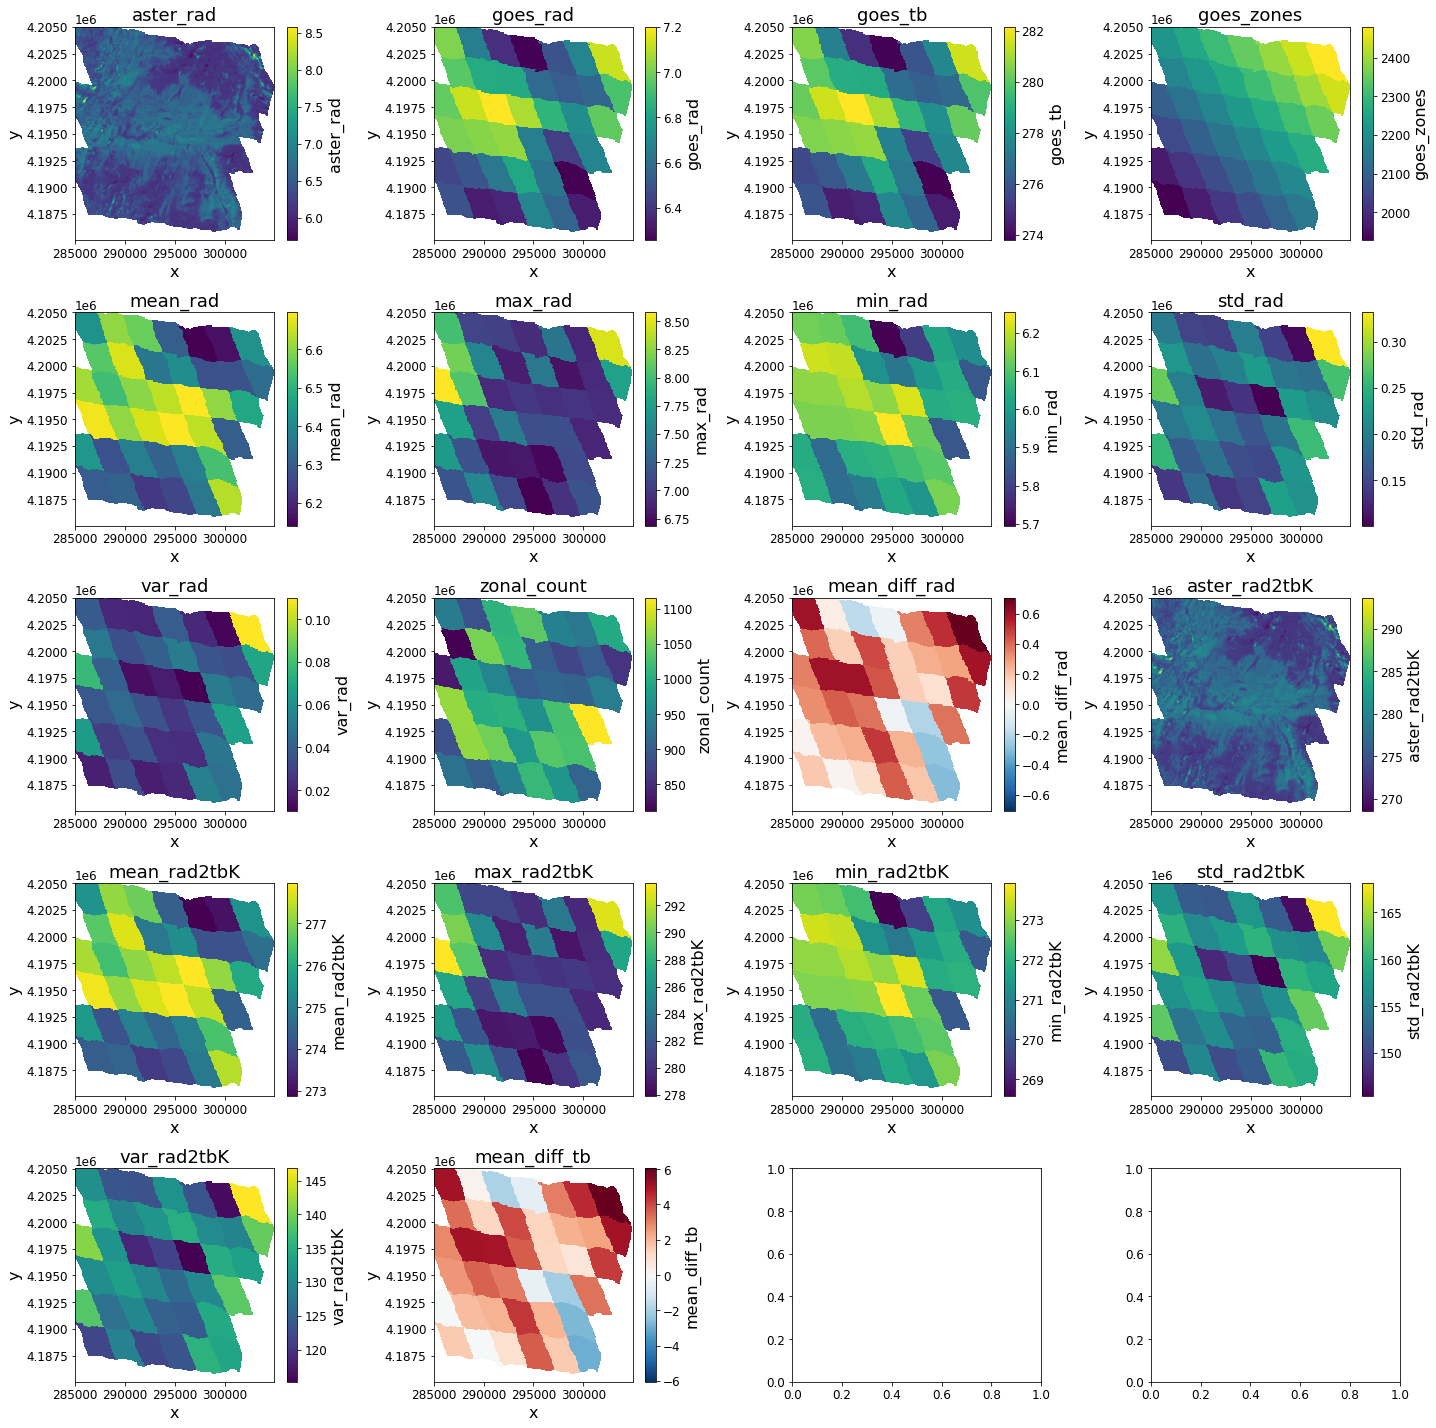

In [19]:
m = 2

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20,20), tight_layout=True)
ax = ax.flatten()

for i, data_var in enumerate(ds_list[m]):
    ds_list[m][str(data_var)].plot(ax=ax[i])
    ax[i].set_title(str(data_var))